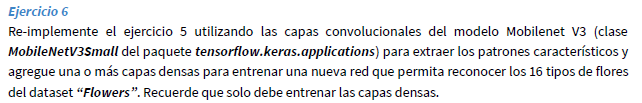

In [1]:
# configuración para notebook con instalación LOCAL
FUENTES_DIR  = '../../Datos-Fuentes/Fuentes/'     # carpeta donde se encuentran archivos .py auxiliares
DATOS_DIR    = '../../Datos-Fuentes/Datos/'      # carpeta donde se encuentran los datasets
MODELOS_DIR  = '../Modelos/'    # carpeta donde se encuentran los modelos
ARCHIVOs_DIR = '../Archivos/'   # carpeta recuperar o copiar archivos

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Importo librerias

In [4]:
from tensorflow.keras.applications import MobileNetV3Small
#from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import LeakyReLU

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten  , Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
import matplotlib.pyplot as plt


## Construyo modelo

In [20]:
# constantes para arquitectura, generación datos y entrenamiento/validacion
IMG_SIZE = (96, 96, 3)  # tamaño de la imagen de entrada
N_CLASSES = 16          # cantidad de clases a identificar
LOTES = 64             # tamaño de lotes para entrenamiento y testeo 
ALFA = 0.00005           # tasa de entrenamiento
EPOCAS = 1000           # cantidad de epocas a entrenar como máximo
PACIENCIA = 40          # parámetro para parada temprana
SEP_TRAIN_TEST = 0.2    # división en entrenamiento y validación 

# %% construye le modelo
# obtiene la arquitectura para el modelo pre-entrenado
feature_model = MobileNetV3Small(
    #input_shape=IMG_SIZE,
    minimalistic=False,
    #include_top=False,
    weights="imagenet",
    include_preprocessing=True,
)

# construye el modelo de manera funcional
layers = Flatten() (feature_model.output)
layers = Dense(256, activation=LeakyReLU())(layers)
layers = BatchNormalization()(layers)
layers = Dropout(0.2)(layers)
layers = Dense(128)(layers)  # Nueva capa con 128 neuronas
layers = LeakyReLU()(layers)
layers = BatchNormalization()(layers)
layers = Dropout(0.2)(layers)
output = Dense(N_CLASSES, activation='softmax')(layers)

model = Model(inputs=feature_model.input, outputs=output)

# The newly added layers are initialized with random values.
# Make sure based model remain unchanged until newly added layers weights get reasonable values.
for layer in feature_model.layers:
    layer.trainable = False 

#Optimizer
opt = Adam(learning_rate=ALFA)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

## Entreno el modelo

In [21]:
IMAGES_DIR = DATOS_DIR + 'FlowersX16'

# construye un generador de imagenes para dividir en entrenamiento y validación
data_generator = ImageDataGenerator(
    validation_split=SEP_TRAIN_TEST
)

# generador para entrenamiento a partir de la carpeta indicada en IMAGES_DIR
train_iter = data_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=IMAGES_DIR, 
            class_mode='categorical',
            batch_size=LOTES,
            subset='training'   # asigna subconjunto segun validation_split del ImageDataGenerator
            )

valid_iter = data_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=IMAGES_DIR, 
            class_mode='categorical',
            batch_size=LOTES,
            subset='validation' # asigna subconjunto segun validation_split del ImageDataGenerator
            )

# Callback para parada temprana
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=PACIENCIA,  
                           restore_best_weights=True)

H = model.fit(
    train_iter,
    validation_data=valid_iter,
    validation_steps= 16,
    epochs=EPOCAS,
    callbacks=[early_stop])

Found 12599 images belonging to 16 classes.
Found 3141 images belonging to 16 classes.
Epoch 1/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.0854 - loss: 3.3557 - val_accuracy: 0.0674 - val_loss: 2.7450
Epoch 2/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.1930 - loss: 2.6885 - val_accuracy: 0.1074 - val_loss: 2.5881
Epoch 3/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.2376 - loss: 2.5094 - val_accuracy: 0.3057 - val_loss: 2.2381
Epoch 4/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.2814 - loss: 2.3352 - val_accuracy: 0.4493 - val_loss: 1.9681
Epoch 5/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.3301 - loss: 2.2111 - val_accuracy: 0.3916 - val_loss: 1.9653
Epoch 6/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.3409 - loss: 2.1469 - val_accuracy: 0.4453 - val_loss: 1.8255
Epoch 7/1000
197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.3626 - loss: 2.0522 - val_accuracy: 0.4697 - val_loss: 1.

## Dibujo accuracy del progreso del entrenamiento

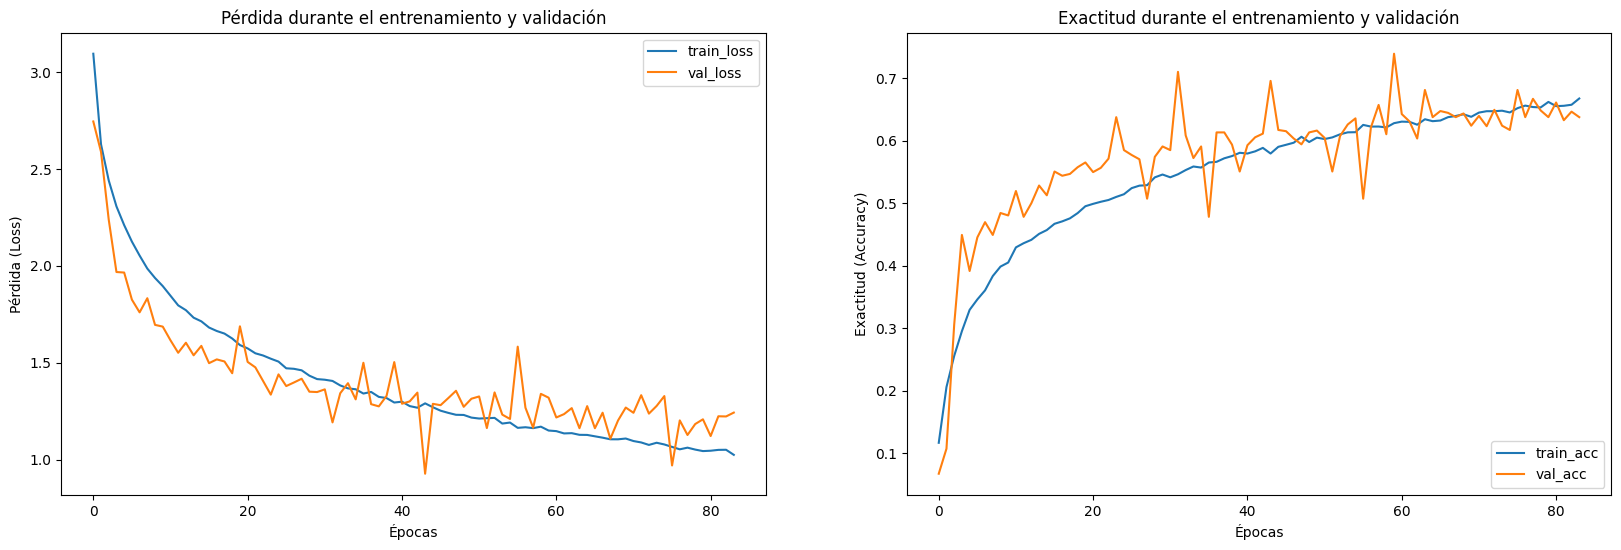

<Figure size 640x480 with 0 Axes>

In [22]:
fig, axs = plt.subplots(1,2, figsize=(20,6))
plt.figure()
axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")
axs[0].set_title("Pérdida durante el entrenamiento y validación")  # Título del gráfico
axs[0].set_xlabel("Épocas")  # Etiqueta del eje X
axs[0].set_ylabel("Pérdida (Loss)")  # Etiqueta del eje Y
axs[0].legend(loc="upper right")  # Muestra la leyenda en la esquina superior derecha

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")
axs[1].set_title("Exactitud durante el entrenamiento y validación")  # Título del gráfico
axs[1].set_xlabel("Épocas")  # Etiqueta del eje X
axs[1].set_ylabel("Exactitud (Accuracy)")  # Etiqueta del eje Y
axs[1].legend(loc="lower right")  # Muestra la leyenda en la esquina inferior derecha

## Evaluo

In [23]:
model.evaluate(train_iter)
model.evaluate(valid_iter)

197/197 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.7047 - loss: 0.9636
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.6262 - loss: 1.2829


[1.2974326610565186, 0.6150907278060913]